# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")

CPU times: user 1.93 s, sys: 261 ms, total: 2.19 s
Wall time: 2.2 s


In [6]:
row_index = metadata.set.isin(["train","validation","test"]) 

metadata = metadata.loc[row_index,:].reset_index(drop = True)

metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


In [7]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


['B_cell' 'B_T_cell_in_one_layer' 'Multiplets' 'Synapses_with_signaling'
 'T_cell_with_B_cell_fragments' 'T_cell' 'No_cell_cell_interaction'
 'Synapses_without_signaling' 'T_cell_with_signaling']


<AxesSubplot:>

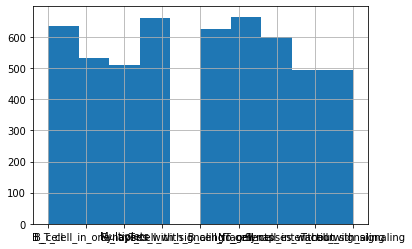

In [8]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [9]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

In [10]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w


Set all random seeds to the specific value, so the results are more reproducable

In [11]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [12]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 160
train_transform = [
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         AddGaussianNoise(mean=0., std=0.005),
        ]
test_transform = [ ]
num_classes = len(metadata.label.unique())

In [14]:

channels = np.asarray(["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"])
selected_channels = np.arange(len(channels))
num_channels = len(selected_channels)
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [15]:
batch_size = 128
num_workers = 4
device="cuda"

In [16]:
channel_importance = pd.read_csv("channel_importance.csv")
channel_importance

,fold,channel,PXPermute,DeepLift,LRP,GuidedGradCAM,IntegratedGradients
0,1,BF,-0.903509,5.130000e-05,881.029748,-8.440000e-09,3.560000e-05
1,1,Antibody,-0.875932,7.140000e-06,39.048419,-6.990000e-09,1.760000e-06
2,1,CD18,-0.891383,3.430000e-06,-58.621100,-9.480000e-09,2.070000e-06
3,1,F-Actin,-0.853113,2.640000e-06,-188.193848,-3.980000e-09,1.860000e-06
4,1,MHCII,-0.683771,-1.320000e-06,-93.692622,-7.710000e-09,-6.530000e-07
5,1,CD3,-0.670556,-1.390000e-06,42.120468,-1.530000e-08,2.070000e-06
6,1,P-CD3zeta,-0.647172,2.840000e-06,-522.217394,3.050000e-10,1.680000e-06
7,1,Live-Dead,-0.909705,8.390000e-06,12.706195,-8.140000e-10,5.830000e-06
8,2,BF,0.000334,1.560000e-05,-10.388792,9.190000e-09,1.940000e-05
9,2,Antibody,0.065707,7.200000e-06,-2.661150,1.930000e-09,7.070000e-06


In [17]:
from sklearn.preprocessing import MinMaxScaler
interpretation_methods = ["PXPermute", "DeepLift", "LRP", "GuidedGradCAM","IntegratedGradients"]
channel_importance.loc[:, interpretation_methods] = MinMaxScaler().fit_transform(channel_importance.loc[:, interpretation_methods])



<AxesSubplot:xlabel='variable', ylabel='value'>

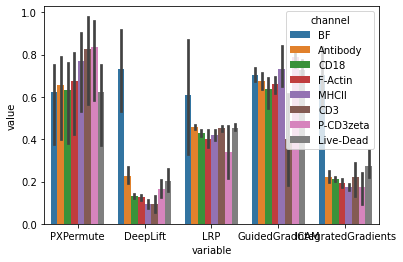

In [18]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            hue = "channel")

In [19]:
channel_importance.channel.unique()

array(['BF', 'Antibody', 'CD18', 'F-Actin', 'MHCII', 'CD3', 'P-CD3zeta',
       'Live-Dead'], dtype=object)

In [20]:
channel_map = {
    'BF':"Ch0", 
    'Antibody':"Ch1", 
    'CD18':"Ch2", 
    'F-Actin':"Ch3", 
    'MHCII':"Ch4", 
    'CD3':"Ch5", 
    'P-CD3zeta':"Ch6",
    'Live-Dead':"Ch7"
}

channel_importance.channel = channel_importance.channel.replace(channel_map)

<AxesSubplot:xlabel='variable', ylabel='value'>

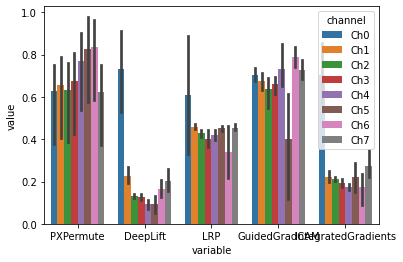

In [21]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            hue = "channel")

In [22]:
def select_top_channels(channel_importance, method, num_top_channels):
    grouped_importance = channel_importance.loc[:,["channel",method]].groupby("channel").mean()
    grouped_importance = grouped_importance.sort_values(by=method, ascending = False) 
    selected_channels = grouped_importance.index[:num_top_channels]
    selected_channels = [int(ch.replace("Ch","")) for ch in selected_channels]
    return selected_channels

In [23]:
def get_statistics(dataloader, selected_channels):
    nmb_channels = len(selected_channels)

    statistics = dict()
    statistics["p01"] = torch.zeros(nmb_channels)
    statistics["p99"] = torch.zeros(nmb_channels)
    for _, data_l in enumerate(tqdm(dataloader), 0):
        image, _ = data_l
        for n in range(nmb_channels):
            statistics["p01"][n] += torch.quantile(image[:, n, :, :], 0.01)
            statistics["p99"][n] += torch.quantile(image[:, n, :, :], 0.99)

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [24]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [ ]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

num_top_channels = 3
skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)


results_with_best_channels = pd.DataFrame(columns = ["method",
                                                     "f1_micro",
                                                     "f1_macro",
                                                     "accuracy"])

for met in interpretation_methods:
    selected_channels = select_top_channels(channel_importance, met , num_top_channels)
    channels = np.asarray([ "Ch" + str(i) for i in selected_channels])
    
    print(met, selected_channels)
    num_of_all_channels = len(channels)
    all_channels = np.arange(num_of_all_channels)
    for train_index, test_index in skf.split(metadata.index.tolist(), metadata["label"]):
        train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)
        label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

        set_of_interesting_classes = metadata.label.unique().tolist()

        num_classes = len(metadata.label.unique())
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([ ] ))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        statistics = get_statistics(train_loader, selected_channels=selected_channels)
        
        stats = dict()
        stats["lower_bound"] = torch.tensor([statistics['p01'][0], 
                                             statistics['p01'][1], 
                                             statistics['p01'][2]])

        stats["upper_bound"] = torch.tensor([statistics['p99'][0], 
                                             statistics['p99'][1], 
                                             statistics['p99'][2]])

        train_transform = [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                AddGaussianNoise(mean=0., std=0.01),
        ]

        validation_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]

        test_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

        validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                              label_map=label_map,
                                              selected_channels=selected_channels,
                                              scaling_factor=scaling_factor,
                                              reshape_size=reshape_size,
                                              transform=transforms.Compose(validation_transform))
        
        test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                        label_map=label_map,
                                        selected_channels=selected_channels,
                                        scaling_factor=scaling_factor,
                                        reshape_size=reshape_size,
                                        transform=
                                        transforms.Compose(test_transform))
        
        

        resnet18_modified = PretrainedModel(num_channels = len(selected_channels),
                                             num_classes = len(set_of_interesting_classes), 
                                             pretrained = True)
        
        lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

        epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                                     name =  "valid_f1_micro", 
                                     on_train = False,
                                     lower_is_better = False)

        epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                                     name =  "valid_f1_macro", 
                                     on_train = False,
                                     lower_is_better = False)

        early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                                       patience=50, 
                                       threshold=0.0001, 
                                       threshold_mode='rel', 
                                       lower_is_better=False)

        checkpoint = Checkpoint(f_params='synapse_formation_DL_method_comparison.pth',
                                monitor='valid_f1_macro_best', load_best=True)
        
        net = NeuralNetClassifier(    
            resnet18_modified, 
            criterion=nn.CrossEntropyLoss,
            lr=0.001,
            batch_size=batch_size,
            max_epochs=1000,
            optimizer=optim.Adam,
            iterator_train__shuffle=True,
            iterator_train__num_workers=num_workers,
            iterator_valid__shuffle=False,
            iterator_valid__num_workers=2,
            callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
                       epoch_scoring_f1_macro, 
                       early_stopping, checkpoint],
            train_split=predefined_split(validation_dataset),
            device="cuda",
            warm_start=True)
        net = net.fit(train_dataset, y = None)
        net.module.load_state_dict(torch.load('synapse_formation_DL_method_comparison.pth')) 
        
        inv_label_map = {v: k for k, v in label_map.items()}

        preds = net.predict(test_dataset)
        preds =  [inv_label_map[int(t)] for t in preds]
        
        results_with_best_channels = results_with_best_channels.append({
            "method":met,
            "f1_micro":f1_score(test_dataset.metadata.label, preds, average="micro"),
            "f1_macro":f1_score(test_dataset.metadata.label, preds, average="macro"),
            "accuracy":accuracy_score(test_dataset.metadata.label, preds),
        },ignore_index = True)
        net = None
        resnet18_modified = None
        torch.cuda.empty_cache()
        print("---------------------------"*3)

PXPermute [6, 5, 4]


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


statistics used: {'p01': tensor([0.0087, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0872, 0.0719])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8832       0.5526            0.4944            0.5526        1.9112     +  7.7581
      2        0.5434       0.6746            0.6335            0.6746        1.1205     +  6.9801
      3        0.4376       0.7823            0.7637            0.7823        0.5969     +  7.1767
      4        0.3436       0.8469            0.8452            0.8469        0.4382     +  6.9280
      5        0.3433       0.8074            0.8024            0.8074        0.4913        6.8157
      6        0.3266       0.7895            0.7831            0.7895        0.6075        6.7818
      7        0.3562       0.7237            0.6860            0.7237        0.9132        6.7890
      8  

     74        0.0031       0.8971            0.8955            0.8971        0.4424        6.7956
     75        0.0047       0.8900            0.8882            0.8900        0.4561        6.7785
     76        0.0096       0.9031            0.9020            0.9031        0.4422     +  6.7583
     77        0.0209       0.8911            0.8875            0.8911        0.5274        6.8476
     78        0.0574       0.8804            0.8777            0.8804        0.5323        6.8323
     79        0.0235       0.8888            0.8866            0.8888        0.5047        6.7900
     80        0.0305       0.8923            0.8907            0.8923        0.4856        6.7647
     81        0.0148       0.8995            0.8976            0.8995        0.4190        6.7598
     82        0.0074       0.8971            0.8948            0.8971        0.4384        6.7684
     83        0.0067       0.9031            0.9013            0.9031        0.4212        6.7477
     84   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([0.0087, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0860, 0.0693])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8200       0.5048            0.4381            0.5048        2.9406     +  6.9649
      2        0.5120       0.6483            0.5586            0.6483        1.2620     +  6.8535
      3        0.4048       0.7333            0.7293            0.7333        0.7665     +  6.8253
      4        0.5009       0.6579            0.6376            0.6579        1.1724        6.7765
      5        0.3648       0.8361            0.8304            0.8361        0.4871     +  6.7979
      6        0.3107       0.8589            0.8573            0.8589        0.3902     +  6.7651
      7        0.2929       0.8636            0.8573            0.8636        0.4080        6.7689
      8  

     74        0.0094       0.8792            0.8753            0.8792        0.5291        6.7797
     75        0.0052       0.8864            0.8816            0.8864        0.5147        6.7496
     76        0.0045       0.8888            0.8836            0.8888        0.5297        6.7534
     77        0.0041       0.8888            0.8840            0.8888        0.5273        6.7430
     78        0.0036       0.8911            0.8869            0.8911        0.5392        6.7606
     79        0.0044       0.8804            0.8743            0.8804        0.5548        6.7905
     80        0.0037       0.8864            0.8809            0.8864        0.5537        6.7664
     81        0.0036       0.8864            0.8813            0.8864        0.5456        6.7901
     82        0.0033       0.8911            0.8865            0.8911        0.5475        6.7631
     83        0.0035       0.8876            0.8826            0.8876        0.5568        6.7639
     84   

100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


statistics used: {'p01': tensor([0.0088, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0863, 0.0717])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8722       0.5622            0.4818            0.5622        2.5125     +  6.9441
      2        0.5172       0.8038            0.7825            0.8038        0.5345     +  6.8378
      3        0.4606       0.7081            0.6811            0.7081        0.8359        6.7868
      4        0.4120       0.8158            0.8101            0.8158        0.5019     +  6.7851
      5        0.3579       0.7727            0.7601            0.7727        0.6563        6.7652
      6        0.3329       0.7919            0.7874            0.7919        0.6194        6.7966
      7        0.3276       0.8457            0.8448            0.8457        0.4408     +  6.7671
      8  

     76        0.0024       0.9043            0.9023            0.9043        0.3930        6.8059
     77        0.0117       0.8876            0.8852            0.8876        0.4279        6.7862
     78        0.0058       0.8995            0.8961            0.8995        0.4037        6.7494
     79        0.0026       0.8959            0.8933            0.8959        0.4366        6.7654
     80        0.0019       0.9019            0.8992            0.9019        0.4099        6.7602
     81        0.0022       0.8983            0.8957            0.8983        0.4249        6.7774
     82        0.0021       0.9079            0.9054            0.9079        0.4127        6.7489
     83        0.0118       0.9019            0.8992            0.9019        0.4161        6.7723
     84        0.0049       0.8983            0.8961            0.8983        0.4128        6.7492
     85        0.0029       0.9019            0.8997            0.9019        0.4035        6.7667
     86   

    157        0.0010       0.9031            0.9004            0.9031        0.4198        6.7740
    158        0.0012       0.9031            0.9004            0.9031        0.4220        6.7849
    159        0.0011       0.9043            0.9018            0.9043        0.4232        6.7671
    160        0.0010       0.9043            0.9012            0.9043        0.4163        6.7662
    161        0.0010       0.9055            0.9030            0.9055        0.4131        6.7550
    162        0.0011       0.9043            0.9014            0.9043        0.4172        6.7728
    163        0.0009       0.9103            0.9076            0.9103        0.4073        6.7593
    164        0.0011       0.9019            0.8991            0.9019        0.4233        6.7784
    165        0.0013       0.9067            0.9042            0.9067        0.4135        6.7873
    166        0.0017       0.9031            0.9002            0.9031        0.4219        6.7413
    167   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.0087, 0.0114, 0.0085]), 'p99': tensor([0.0113, 0.0872, 0.0700])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.8396       0.6376            0.6311            0.6376        1.5434     +  6.9446
      2        0.4677       0.7177            0.7016            0.7177        0.9039     +  6.8280
      3        0.4753       0.6794            0.6427            0.6794        1.0765        6.7887
      4        0.4330       0.8170            0.8116            0.8170        0.5655     +  6.8016
      5        0.3296       0.8014            0.7871            0.8014        0.5644        6.7576
      6        0.2935       0.8313            0.8241            0.8313        0.6114     +  6.7640
      7        0.2988       0.8660            0.8601            0.8660        0.4507     +  6.7841
      8  

     76        0.0031       0.8900            0.8873            0.8900        0.5139        6.7651
     77        0.0045       0.8947            0.8917            0.8947        0.5033        6.7850
     78        0.0032       0.8923            0.8892            0.8923        0.5246        6.7753
     79        0.0028       0.8911            0.8880            0.8911        0.5400        6.7622
     80        0.0038       0.8935            0.8897            0.8935        0.5324        6.7539
     81        0.0173       0.8816            0.8768            0.8816        0.5719        6.8073
     82        0.0117       0.8995            0.8969            0.8995        0.5010        6.8118
     83        0.0217       0.8888            0.8859            0.8888        0.5694        6.7621
     84        0.0601       0.8708            0.8656            0.8708        0.6312        6.7789
     85        0.0441       0.8780            0.8725            0.8780        0.5956        6.7577
     86   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.0087, 0.0115, 0.0085]), 'p99': tensor([0.0113, 0.0863, 0.0699])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        0.7762       0.5754            0.5015            0.5754        2.0429     +  6.9193
      2        0.5020       0.7739            0.7395            0.7739        0.7402     +  6.8336
      3        0.4428       0.8122            0.8086            0.8122        0.5485     +  6.8022
      4        0.3366       0.8074            0.7906            0.8074        0.5854        6.7729
      5        0.3638       0.8002            0.7950            0.8002        0.5962        6.7672
      6        0.3151       0.8409            0.8331            0.8409        0.4803     +  6.7896
      7        0.3253       0.8361            0.8293            0.8361        0.4446        6.7995
      8  

     75        0.0049       0.8756            0.8725            0.8756        0.6165        6.7599
     76        0.0083       0.8684            0.8656            0.8684        0.6114        6.7484
     77        0.0078       0.8720            0.8685            0.8720        0.5889        6.7453
     78        0.0099       0.8732            0.8692            0.8732        0.6056        6.7834
     79        0.0042       0.8684            0.8651            0.8684        0.6028        6.7635
     80        0.0043       0.8756            0.8725            0.8756        0.5910        6.7457
     81        0.0039       0.8768            0.8734            0.8768        0.5857        6.7402
     82        0.0035       0.8780            0.8745            0.8780        0.5912        6.7488
     83        0.0074       0.8792            0.8749            0.8792        0.5728        6.7742
     84        0.0044       0.8756            0.8717            0.8756        0.5663        6.7839
     85   

100%|██████████| 27/27 [00:21<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1811, 0.0000, 0.0080]), 'p99': tensor([0.2077, 0.0056, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1275       0.4545            0.4336            0.4545        1.8522     +  6.9186
      2        0.8495       0.5813            0.5803            0.5813        1.0136     +  6.8359
      3        0.7596       0.4761            0.4374            0.4761        1.4852        6.7882
      4        0.6861       0.6220            0.5842            0.6220        1.1086     +  6.7546
      5        0.6611       0.5526            0.5231            0.5526        1.2548        6.8106
      6        0.6461       0.6208            0.6035            0.6208        1.0627     +  6.7935
      7        0.6601       0.6089            0.5465            0.6089        1.1234        6.8349
      8  

     75        0.0042       0.7285            0.7248            0.7285        1.4620        6.7974
     76        0.0044       0.7213            0.7169            0.7213        1.4689        6.7185
     77        0.0083       0.7249            0.7207            0.7249        1.5064        6.7338
     78        0.0152       0.7297            0.7215            0.7297        1.5252        6.7663
     79        0.0064       0.7213            0.7155            0.7213        1.5130        6.7397
     80        0.0070       0.7237            0.7189            0.7237        1.5014        6.7652
     81        0.0105       0.7153            0.7097            0.7153        1.5148        6.7739
     82        0.0070       0.7261            0.7220            0.7261        1.5173        6.7502
     83        0.0051       0.7201            0.7167            0.7201        1.5098        6.7569
     84        0.0039       0.7249            0.7195            0.7249        1.5185        6.7521
     85   

    157        0.0012       0.7333            0.7298            0.7333        1.5572        6.7745
    158        0.0018       0.7285            0.7259            0.7285        1.5498        6.7536
    159        0.0018       0.7189            0.7142            0.7189        1.5530        6.7509
    160        0.0021       0.7261            0.7220            0.7261        1.5453        6.7704
    161        0.0025       0.7285            0.7237            0.7285        1.5626        6.7468
    162        0.0033       0.7321            0.7282            0.7321        1.5746        6.7330
    163        0.0015       0.7321            0.7281            0.7321        1.5443        6.7709
    164        0.0018       0.7309            0.7273            0.7309        1.5485        6.7627
    165        0.0019       0.7249            0.7208            0.7249        1.5446        6.7627
    166        0.0031       0.7261            0.7222            0.7261        1.5772        6.7149
    167   

100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


statistics used: {'p01': tensor([1.8099e-01, 9.0445e-06, 8.0586e-03]), 'p99': tensor([0.2076, 0.0056, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1241       0.4749            0.3927            0.4749        1.6021     +  6.9556
      2        0.7676       0.4689            0.4261            0.4689        1.6694     +  6.8464
      3        0.7163       0.6555            0.6353            0.6555        0.9251     +  6.8016
      4        0.6515       0.5742            0.5351            0.5742        1.3371        6.7972
      5        0.6110       0.6615            0.5913            0.6615        0.9644        6.7650
      6        0.6460       0.6483            0.6221            0.6483        0.9466        6.7686
      7        0.5722       0.6352            0.6062            0.6352        1.0022        6.77

     74        0.0151       0.7452            0.7393            0.7452        1.3132        6.7643
     75        0.0129       0.7404            0.7367            0.7404        1.3293        6.7693
     76        0.0086       0.7416            0.7355            0.7416        1.3314        6.7875
     77        0.0099       0.7380            0.7328            0.7380        1.3078        6.7743
     78        0.0065       0.7464            0.7424            0.7464        1.3244        6.7699
     79        0.0065       0.7464            0.7394            0.7464        1.3218        6.7648
     80        0.0058       0.7476            0.7418            0.7476        1.3390        6.7954
     81        0.0082       0.7380            0.7328            0.7380        1.3589        6.7855
     82        0.0070       0.7440            0.7375            0.7440        1.3396        6.7456
     83        0.0078       0.7356            0.7336            0.7356        1.3431        6.7651
     84   

100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


statistics used: {'p01': tensor([0.1810, 0.0000, 0.0081]), 'p99': tensor([0.2076, 0.0057, 0.0104])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.0874       0.4833            0.4291            0.4833        2.2107     +  6.9324
      2        0.7877       0.5993            0.5959            0.5993        1.0383     +  6.8179
      3        0.7220       0.6495            0.6498            0.6495        0.9003     +  6.7698
      4        0.6436       0.5467            0.5078            0.5467        1.1548        6.7549
      5        0.6417       0.6053            0.5799            0.6053        1.1069        6.7345
      6        0.5939       0.5395            0.5162            0.5395        1.3922        6.7740
      7        0.5542       0.6711            0.6675            0.6711        0.9475     +  6.7438
      8  

     75        0.0049       0.7440            0.7399            0.7440        1.4974     +  6.7753
     76        0.0293       0.6998            0.6886            0.6998        1.7176        6.8339
     77        0.0126       0.7177            0.7176            0.7177        1.5941        6.8122
     78        0.0066       0.7428            0.7359            0.7428        1.5130        6.7465
     79        0.0045       0.7321            0.7259            0.7321        1.5167        6.7540
     80        0.0039       0.7333            0.7293            0.7333        1.5188        6.7663
     81        0.0040       0.7285            0.7239            0.7285        1.5688        6.7479
     82        0.0062       0.7285            0.7257            0.7285        1.5480        6.7595
     83        0.0026       0.7213            0.7194            0.7213        1.5867        6.8056
     84        0.0026       0.7249            0.7229            0.7249        1.5528        6.7764
     85   

100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


statistics used: {'p01': tensor([0.1810, 0.0000, 0.0080]), 'p99': tensor([0.2077, 0.0056, 0.0105])}
  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp     dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  ------
      1        1.1287       0.4629            0.3919            0.4629        2.1929     +  6.9010
      2        0.8062       0.5969            0.5022            0.5969        1.1571     +  6.8219
      3        0.7190       0.6053            0.5607            0.6053        1.0505     +  6.7654
      4        0.6374       0.5383            0.5139            0.5383        1.4373        6.7984
      5        0.6085       0.6364            0.5715            0.6364        1.0409     +  6.7704
      6        0.6306       0.6100            0.5947            0.6100        0.9813     +  6.7365
      7        0.5217       0.5945            0.5570            0.5945        1.2042        6.8092
      8  

     74        0.0024       0.7153            0.7090            0.7153        1.5821        6.7845
     75        0.0040       0.7153            0.7070            0.7153        1.6064        6.7698
     76        0.0110       0.7177            0.7157            0.7177        1.6569        6.7619
     77        0.0045       0.7261            0.7209            0.7261        1.5634        6.7783
     78        0.0045       0.7177            0.7135            0.7177        1.6217        6.7536
     79        0.0026       0.7189            0.7148            0.7189        1.6372        6.7932
     80        0.0026       0.7189            0.7138            0.7189        1.6775        6.7567
     81        0.0025       0.7249            0.7180            0.7249        1.6287        6.7782
     82        0.0035       0.7261            0.7214            0.7261        1.6393        6.8166
     83        0.0137       0.7153            0.7075            0.7153        1.6227        6.7850
     84   

In [ ]:
results_with_best_channels

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [ ]:
import seaborn as sns
sns.barplot(data = results_with_best_channels, 
            x = "method", 
            y = "f1_macro",
           palette = ["gray"])

In [ ]:
results_with_best_channels.to_csv("results_with_best_channels.csv", index = True)